In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import rand, randn
from scipy.linalg import inv, svd
from scipy.optimize import linprog


# Compute null space
def null_space(A, rcond=None):
    """
    Compute null spavce of matrix XProjection on half space defined by {v| <v,w> = c}
    Arguments:
        A {numpy.ndarray} -- matrix whose null space is desired
        rcond {float} -- intercept
    Returns:
        Q {numpy.ndarray} -- matrix whose (rows?) span null space of A
    """
    u, s, vh = svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

### End Helper Functions


def altproj(A, B, v0, n):
    uw = np.hstack([A, B]) @ null_space(np.hstack([A, -B]))
    if uw.shape[1] == 0:
        v0_uw = np.zeros(v0.shape[0])
    else:      
        puw = np.linalg.lstsq(uw,v0,rcond=None)[0]
        v0_uw = np.dot(uw,puw)
    v = v0
    err = []
    
    for i in range(2*n):
        if i%2==0:
            pa = np.linalg.lstsq(A,v,rcond=None)[0]
            v = np.dot(A,pa)
        else:
            pb = np.linalg.lstsq(B,v,rcond=None)[0]
            v = np.dot(B,pb)
        
            err_v = np.abs(v-v0_uw)
            err.append(np.max(err_v))
    
    err = np.array(err)
    
    return v, err


# Exercise 2: Kaczmarz algorithm for solving linear systems
def kaczmarz(A, b, I):
    m = A.shape[0]
    v = np.zeros(A.shape[1])
    X = []
    err = []
    
    for i in range (I):
        for j in range(m):
            pj = (np.dot(v,A[j])-b[j])/(np.dot(A[j],A[j]))
            v = v - pj*A[j]
            
        X.append(v)
        err_v = np.abs(np.dot(A,v)-b)
        err.append(np.max(err_v))
    
    X = np.array(X)
    X = X.T
    err = np.array(err)
   
    return X, err

# Exercise 4: Alternating projection to satisfy linear inequalities
def lp_altproj(A, b, I, s=1):
    m = A.shape[0]
    v = np.zeros(A.shape[1])
    err = []
    
    for i in range(I):
        for j in range(m):
            if np.dot(v,A[j])>=b[j]:
                v = v
            else:
                pj = (np.dot(v,A[j])-b[j])/(np.dot(A[j],A[j]))
                v = v - s*pj*A[j]
        
        err_v = b-np.dot(A,v)
        err.append(np.max(err_v))
        
    err = np.array(err)
    
    return v, err

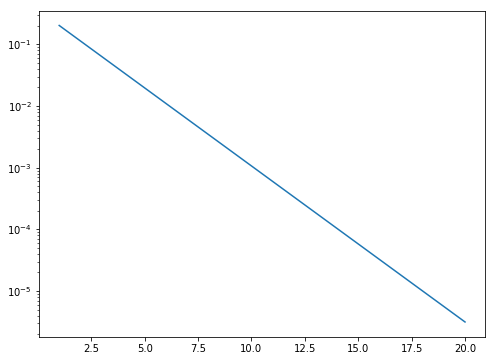

In [2]:
A = np.array([[3, 1, 4, 1, 5], [2, 5, 11, 17, 23], [3, 7, 13, 19, 29]]).T
B = np.array([[1, 2, 2, 2, 6], [1, 0, 1, 0, -3], [2.5, 6, 12, 18, 26]]).T
v0 = np.array([1, 2, 3, 4, 5])
n = 20
v, err = altproj(A, B, v0, n)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, n + 1), err)

In [4]:
for i in range(err.shape[0]):
    if err[i]<0.0001:
        print(i+1)
        print("is required so that err is at most 0,0001")
        break

15
is required so that err is at most 0,0001


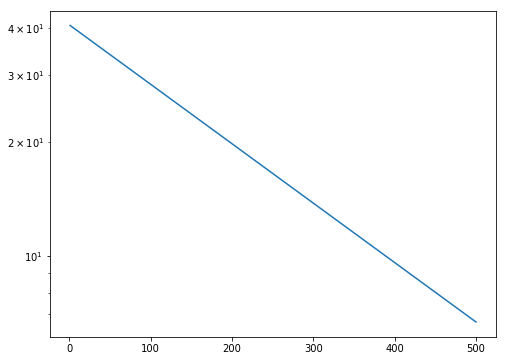

In [5]:
A = np.array([[2, 5, 11, 17, 23], [3, 7, 13, 19, 29]])
b = np.array([228, 227])
I = 500
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

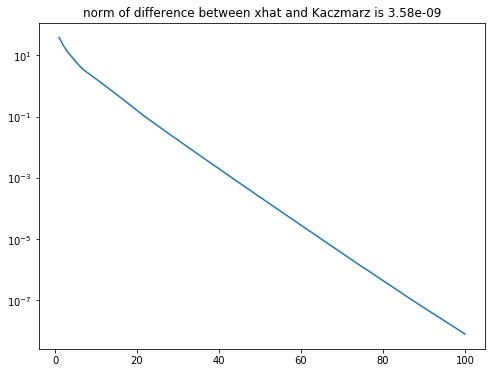

In [6]:
def minimum_norm(A):
    inverse = inv(np.dot(A,A.T))
    
    return np.dot(A.T,inverse)


A = randn(500, 1000)
b = A @ randn(1000)
I = 100
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x_hat = np.dot(minimum_norm(A),b) 
x_hat_err = x_hat - X[:,-1] 

plt.title(f'norm of difference between xhat and Kaczmarz is {np.linalg.norm(x_hat - X[:, -1]):.2e}');

     con: array([], dtype=float64)
     fun: 1.829203455372408e-12
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([8.86402063e-13, 3.81028542e-13, 1.00000000e+00])
  status: 0
 success: True
       x: array([1.50428206e-12, 2.00000000e+00, 1.00000000e+00])
True True


array([0., 2., 1.])

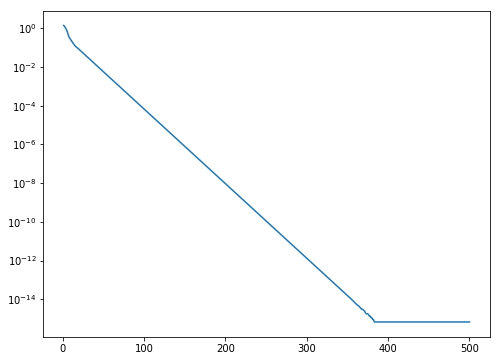

In [7]:
c = np.array([3, -1, 2])
A = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6]])
b = np.array([-1, 2, 1])

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res)

I = 500
# Do not forget constraint xi >= 0
A0 = np.vstack((-1*c,np.eye(A.shape[1])))
A1 = np.vstack((A,A0))
b0 = np.zeros(1+A.shape[1])
b1 = np.hstack((b,b0))
x, err = lp_altproj(A1, b1, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x = np.round(x,10)
print(np.all(A @ x - b >= 0), np.all(x >= 0))
x

In [9]:
for i in range(err.shape[0]):
    if err[i]<0.0001:
        print(i+1)
        print("is required so that err is at most 0,0001")
        break

325
is required so that err is at most 0,0001


True True [-1000.000001]
-1198.5327823524437


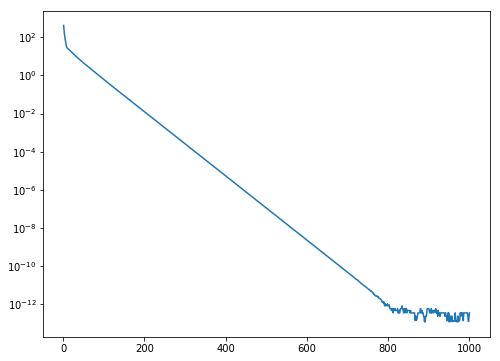

In [8]:
np.random.seed(0)
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])

I, ep = 1000, 1e-6
# Do not forget constraint xi >= 0, and c^T x <= -1000
A0 = np.vstack((-1*c,np.eye(A.shape[1])))
A1 = np.vstack((A,A0))
b0 = np.hstack(([1000],np.zeros(A.shape[1])))
b1 = np.hstack((b,b0))
x, err = lp_altproj(A1, b1 + ep, I)
print(np.all(A @ x - b > 0), np.all(x > 0), c.reshape(1, -1) @ x)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * 1000, method='interior-point')
print(res.fun)